In [1]:
# Load the Libraries

import numpy as np
import matplotlib.pyplot as plt

<a name="2"></a>
## Anomaly detection

<a name="2.1"></a>
### Problem Statement

In this exercise, you will implement an anomaly detection algorithm to
detect anomalous behavior in server computers.

The dataset contains two features - 
   * throughput (mb/s) and 
   * latency (ms) of response of each server.

While your servers were operating, you collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$. 
* You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your
dataset. 
* You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing.
* On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. 
* After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions. 

<a name="2.2"></a>
### Data Set

You will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into the variables `X_train`, `X_val` and `y_val` 
    - You will use `X_train` to fit a Gaussian distribution 
    - You will use `X_val` and `y_val` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [2]:
def load_data():
    X = np.load("data/X_part1.npy")
    X_val = np.load("data/X_val_part1.npy")
    y_val = np.load("data/y_val_part1.npy")
    return X, X_val, y_val

In [3]:
X_train, X_val, y_val = load_data()

In [4]:
# Display the First Five Elements of X_train
print("The First 5 Elements of X_train Are:\n", X_train[:5])  
print("\n")
# Display the First Five Elements of X_val
print("The First 5 Elements of X_val Are:\n", X_val[:5])
print("\n")
# Display the First Five Elements of y_val
print("The First 5 Elements of y_val Are:\n", y_val[:5])  

The First 5 Elements of X_train Are:
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]


The First 5 Elements of X_val Are:
 [[15.79025979 14.9210243 ]
 [13.63961877 15.32995521]
 [14.86589943 16.47386514]
 [13.58467605 13.98930611]
 [13.46404167 15.63533011]]


The First 5 Elements of y_val Are:
 [0 0 0 0 0]


In [5]:
print ('The Shape of X_train is:', X_train.shape)
print ('The Shape of X_val is:', X_val.shape)
print ('The Shape of y_val is: ', y_val.shape)

The Shape of X_train is: (307, 2)
The Shape of X_val is: (307, 2)
The Shape of y_val is:  (307,)


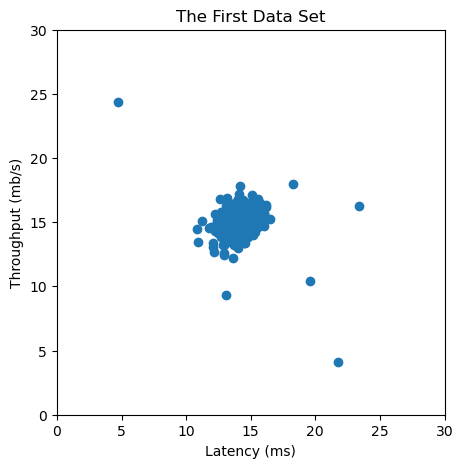

In [6]:
# Plot the Data

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(X_train[:,0], X_train[:,1])

plt.title("The First Data Set")
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

plt.axis([0, 30, 0, 30])

plt.show()

<a name="2.3"></a>
### Gaussian Distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ you want to estimate the Gaussian distribution for each
of the features $x_i$. 

* Recall that the Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

### Estimating Parameters for a Gaussian Distribution

**Implementation**: 

Your task is to complete the code in `estimate_gaussian` below.

<a name="ex01"></a>
### Exercise 1

Please complete the `estimate_gaussian` function below to calculate `mu` (mean for each feature in `X`) and `var` (variance for each feature in `X`). 

You can estimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th
feature by using the following equations. To estimate the mean, you will
use:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance you will use:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [7]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all the features 
    in the dataset.
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
    """ 
    # LOOP VERSION
    mu = np.zeros(n)
    var = np.zeros(n)
    
    # Mean Calculation
    for j in range(n):
        for i in range(m):
            mu[j] += X[i,j]
    mu /= m
    
    # Variance Calculation
    for j in range(n):
        for i in range(m):
            var[j] += ((X[i,j] - mu[j])**2)
    var /= m
    """
    
    # VECTORIZED VERSION
    mu = (1/m) * (np.sum(X, axis=0))
    var = (1/m) * (np.sum((X-mu)**2, axis=0))
            
    return mu, var

In [8]:
# Estimate Mean and Variance of Each Feature
mu, var = estimate_gaussian(X_train)              

print("Mean of Each Feature:", mu)
print("Variance of Each Feature:", var)

Mean of Each Feature: [14.11222578 14.99771051]
Variance of Each Feature: [1.83263141 1.70974533]


### Selecting the Threshold $\epsilon$

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability.  

* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 

In this section, you will complete the code in `select_threshold` to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

* For this, we will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

<a name="ex02"></a>
### Exercise 2
Please complete the `select_threshold` function below to find the best threshold to use for selecting outliers based on the results from the validation set (`p_val`) and the ground truth (`y_val`). 

* In the provided code `select_threshold`, there is already a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. 

* You need to implement code to calculate the F1 score from choosing `epsilon` as the threshold and place the value in `F1`. 

  * Recall that if an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
  * Then, you can compute precision and recall by: 
   $$\begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn},
   \end{aligned}$$ where
    * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
    * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
    * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

**Implementation Note:** 
In order to compute $tp$, $fp$ and $fn$, you may be able to use a vectorized implementation rather than loop over all the examples

In [9]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val).
    
    Args:
        y_val (ndarray): Ground truth on Validation Set
        p_val (ndarray): Results on Validation Set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 Score by Choosing Epsilon as Threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        predictions = p_val < epsilon
        
        # Actual: True, Predicted: True
        tp = np.sum((predictions == 1) & (y_val == 1))
        # Actual: False, Predicted: True
        fp = np.sum((predictions == 1) & (y_val == 0))
        # Actual: True, Predicted: False
        fn = np.sum((predictions == 0) & (y_val == 1))
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        F1 = 2 * prec * rec / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [10]:
def multivariate_gaussian(X, mu, var):
    """
    Computes the probability 
    density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and var. If var is a matrix, it is
    treated as the covariance matrix. If var is a vector, it is treated
    as the var values of the variances in each dimension (a diagonal
    covariance matrix).
    """
    
    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p

In [11]:
# Returns the Density of the Multivariate Normal at Each Data Point (Row) of X_train
p = multivariate_gaussian(X_train, mu, var)

In [12]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print(f"Best Epsilon Found Using Cross-Validation: {epsilon}")
print(f"Best F1 on Cross Validation Set: {F1}")

Best Epsilon Found Using Cross-Validation: 8.990852779269493e-05
Best F1 on Cross Validation Set: 0.8750000000000001


/var/folders/vg/_31zmxtd0sqbfk6y_b5hc92c0000gn/T/ipykernel_73963/3742084320.py:33: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp + fp)
